In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import humanfriendly
from IPython.display import display
from loguru import logger as LOG
import tqdm
import time

In [4]:
mpl.rc('figure', facecolor='white')
print(mpl.rcParams['figure.facecolor'])

white


In [5]:
def display_df_info(df, name=None):
    print(f'{name or ""} {len(df)} rows')
    columns = []
    for col in df.columns:
        info = {
            'column': col, 
            'dtype': df[col].dtype,
            'memory_usage': humanfriendly.format_size(df[col].nbytes),
            'num_unique': df[col].nunique(),
            'num_null': df[col].isnull().sum(),
        }
        try:
            info['min'] = df[col].min()
            info['max'] = df[col].max()
        except (TypeError, ValueError):
            cnts = df[col].value_counts()
            info['min'] = cnts.idxmin()
            info['max'] = cnts.idxmax()
        columns.append(info)
    info = pd.DataFrame.from_records(columns)
    display(info)

In [6]:
df_train = pd.read_msgpack('data/z4_merge_1.msgpack')
df_validate = pd.read_msgpack('data/z4_merge_2.msgpack')
df_test = pd.read_msgpack('data/z4_merge_3.msgpack')

In [7]:
dfs = dict(train=df_train, validate=df_validate, test=df_test)

In [42]:
raw_columns = [
    'user_id', 'merchant_id', 'coupon_id', 'discount_name',
    'date_received', 'date_received_name', 'date', 'date_name',
]
for df_name, df in dfs.items():
    columns = [x for x in raw_columns if x in df.columns]
    display_df_info(df[columns], df_name)

train 137167 rows


""


validate 258446 rows


""


test 113640 rows


""


In [1]:
import lightgbm as lgb

/Users/kk/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
model = lgb.Booster(model_file='data/model-lgb-20181230-145621.dat')
model

In [21]:
items = list(zip(model.feature_name(), model.feature_importance()))
df = pd.DataFrame.from_records(items, columns=['feature', 'score'])
df = df.sort_values('score', ascending=False)
df

,feature,score
125,merchant_offline_buy_without_coupon_distance_mean,4426
132,merchant_offline_buy_without_coupon_user_usage...,4202
129,merchant_offline_buy_without_coupon_user_count,2889
243,user_offline_buy_without_coupon_merchant_count,2865
7,coupon_offline_received_coupon_user_count,2655
44,distance,2518
174,merchant_offline_transfer_rate_received_coupon...,2501
130,merchant_offline_buy_without_coupon_user_nunique,2398
300,user_online_coupon_buy_without_coupon_merchant...,2279
131,merchant_offline_buy_without_coupon_user_usage...,2238


In [ ]:
lgb.create_tree_digraph(model, 100)

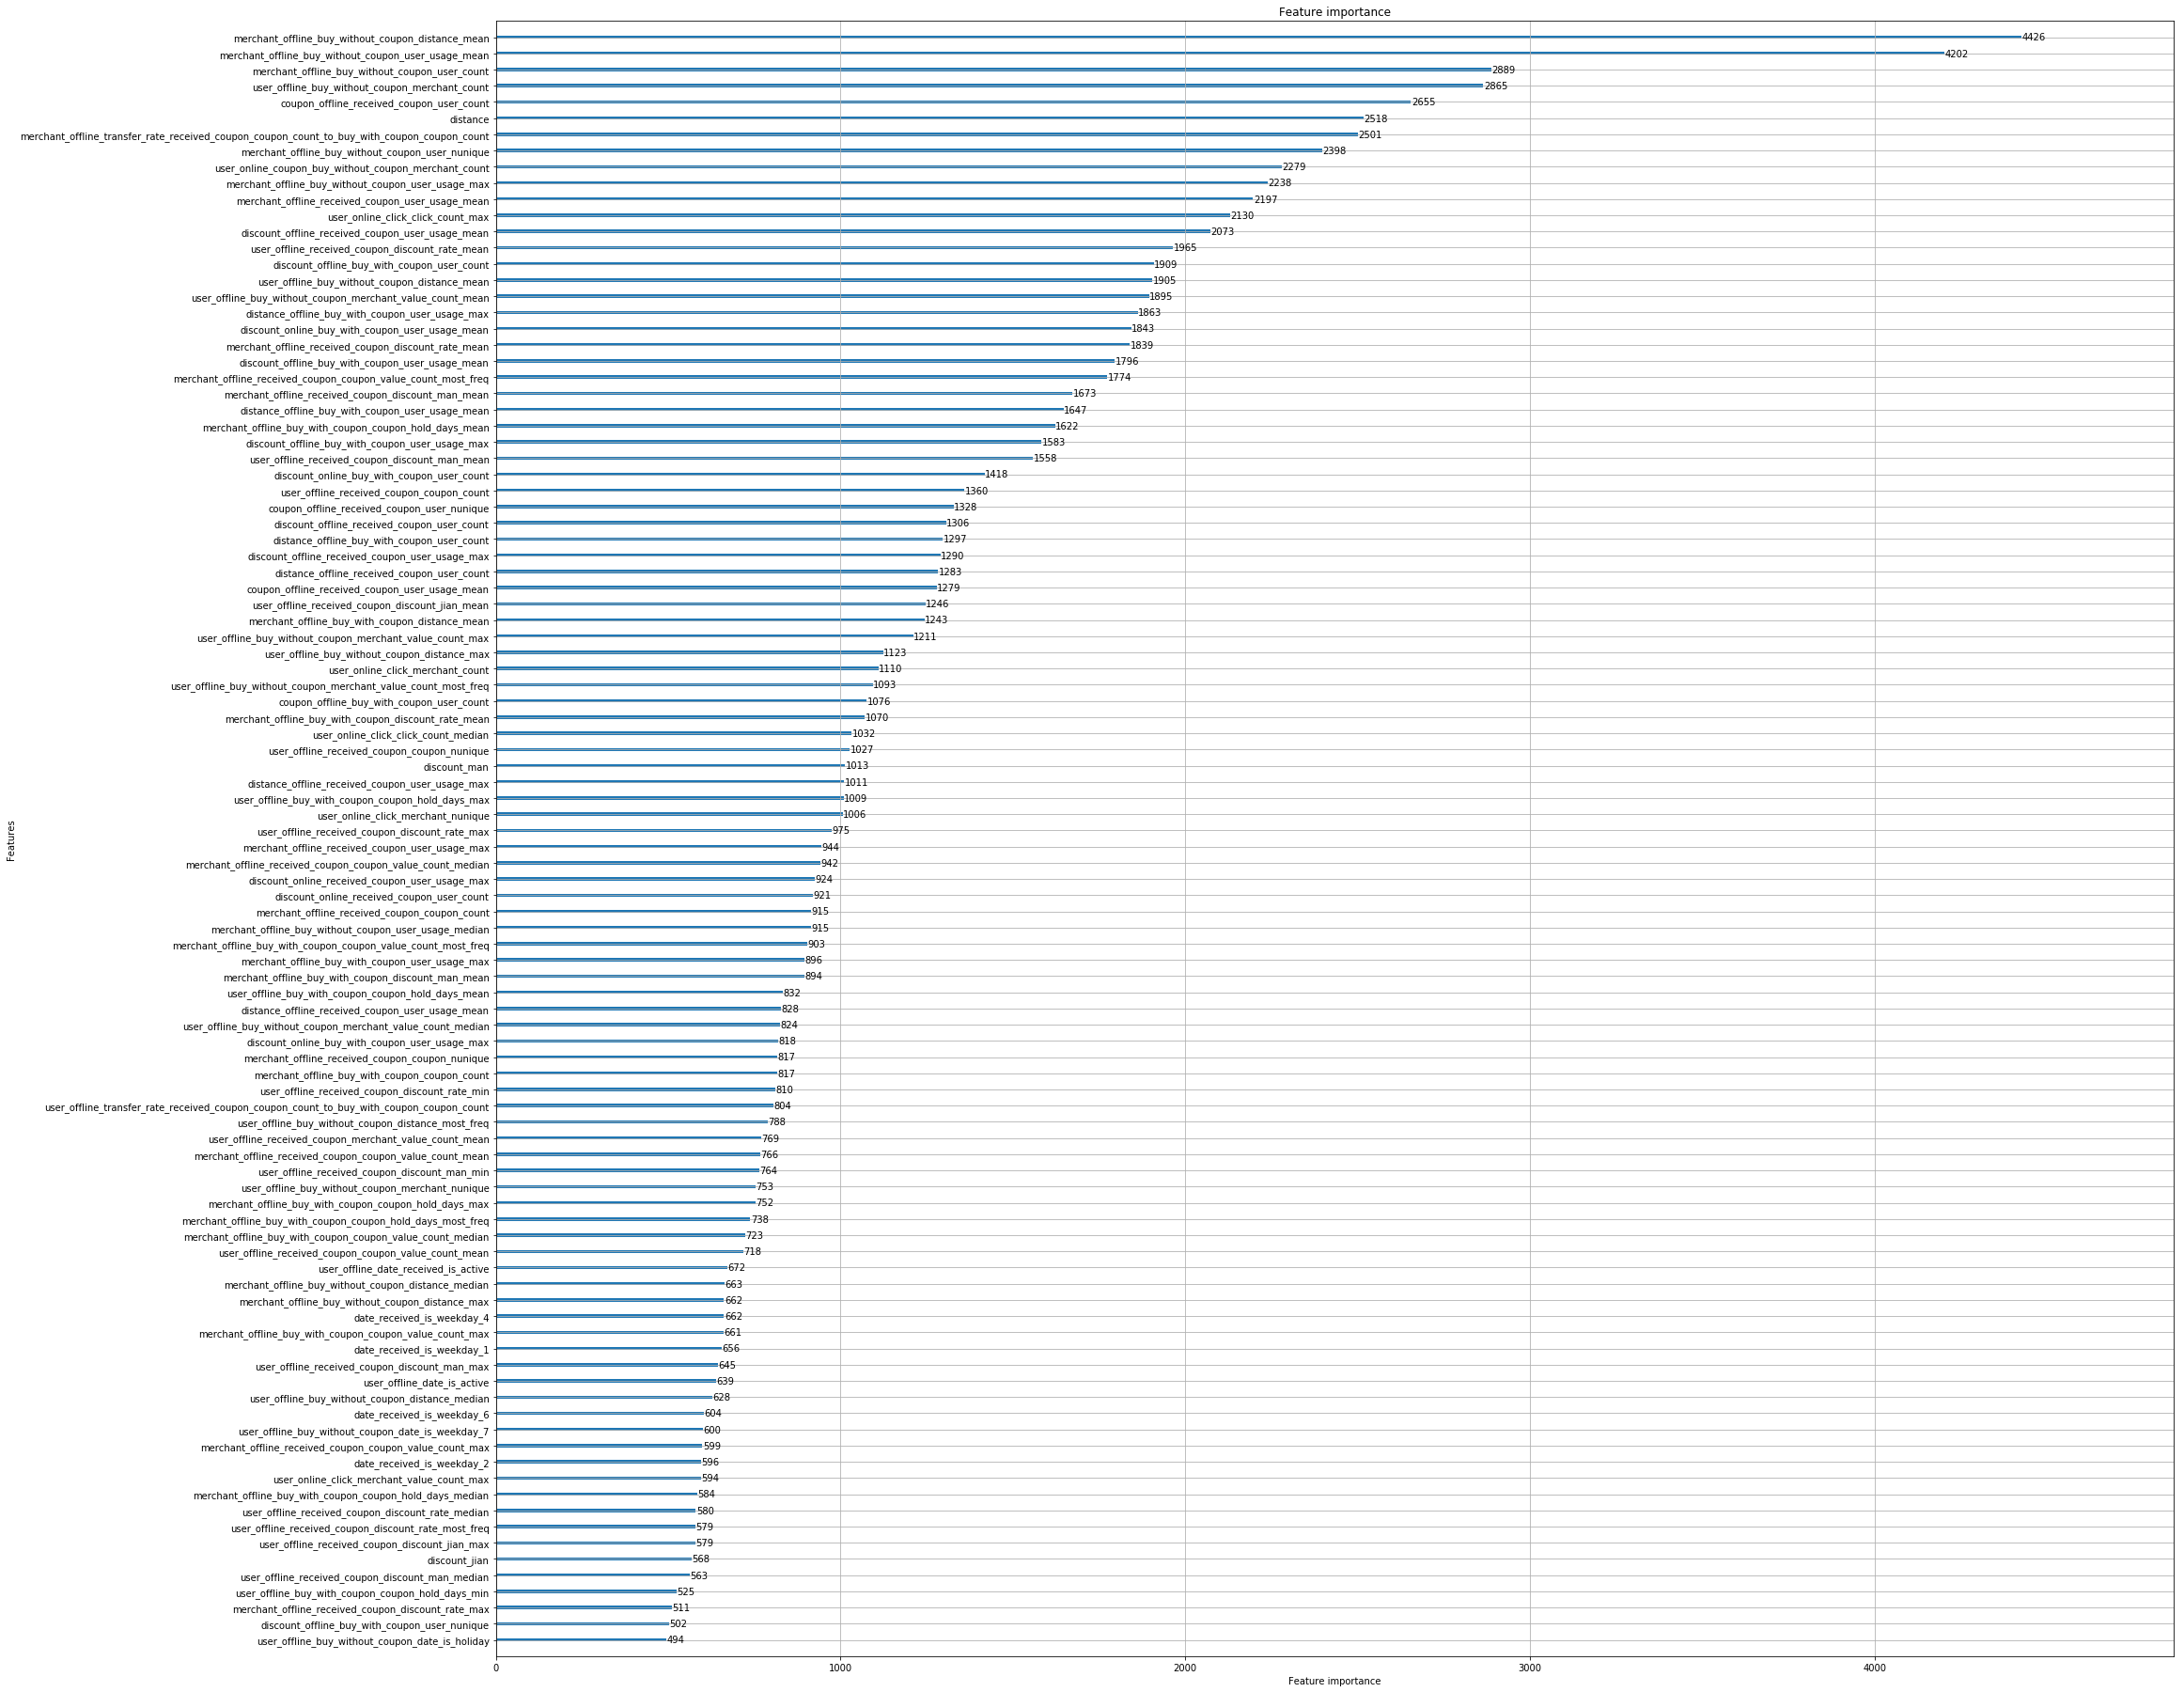

In [24]:
lgb.plot_importance(model, max_num_features=100, figsize=(32, 32))

In [7]:
stats = []
compares = [('train', 'validate'), ('train', 'test'), ('validate', 'test')]
for df_name, df_base_name in compares:
    for column in ['user_id', 'merchant_id', 'coupon_id']:
        df, df_base = dfs[df_name], dfs[df_base_name]
        if column in df.columns and column in df_base.columns:
            a = set(df[column].unique())
            b = set(df_base[column].unique())
            miss = b - a
            stats.append(( df_name, df_base_name, column, len(a), len(b), len(miss), len(miss) / len(b), list(miss)[:4] ))
stats = pd.DataFrame.from_records(stats)
stats.columns = ['dataframe', 'base_dataframe', 'column', 'total', 'base_total', 'num_miss', 'miss_ratio', 'miss']
stats

,dataframe,base_dataframe,column,total,base_total,num_miss,miss_ratio,miss
0,train,validate,user_id,234724,76257,40546,0.531702,"[4, 6553604, 786439, 1703951]"
1,train,validate,merchant_id,4878,2705,302,0.111645,"[6657, 514, 4, 2053]"
2,train,validate,coupon_id,7598,3348,874,0.261051,"[11249, 7614, 9646, 3094]"
3,train,test,user_id,234724,76309,29516,0.386796,"[6684672, 524296, 6946838, 4980766]"
4,train,test,merchant_id,4878,1559,242,0.155228,"[2053, 6, 8200, 1032]"
5,train,test,coupon_id,7598,2050,1251,0.610244,"[11249, 7614, 9306, 9646]"
6,validate,test,user_id,76257,76309,52206,0.684139,"[6684672, 262145, 1835014, 524296]"
7,validate,test,merchant_id,2705,1559,366,0.234766,"[4099, 6, 4105, 8202]"
8,validate,test,coupon_id,3348,2050,1063,0.518537,"[12000, 7440, 9306, 896]"


In [8]:
def split_column_name(name):
    if name in df_train.columns:
        dtype = df_train[name].dtype.name
    else:
        dtype = 'NA'
    parts = name.split('_', maxsplit=1)
    return parts[0], name, dtype

items = list(map(split_column_name, df_train.columns))
df = pd.DataFrame.from_records(items, columns=['prefix', 'name', 'dtype'])
df

,prefix,name,dtype
0,user,user_id,int64
1,merchant,merchant_id,int64
2,coupon,coupon_id,object
3,distance,distance,float64
4,date,date_received,datetime64[ns]
5,discount,discount_name,object
6,is,is_dazhe,bool
7,is,is_manjian,bool
8,discount,discount_man,float64
9,discount,discount_jian,float64


In [9]:
df.groupby(['prefix', 'dtype']).size().to_frame('count')

count
prefix   dtype                
coupon   float64            14
         object              1
date     bool               11
         datetime64[ns]      1
         object              1
discount float64            31
         object              1
distance float64             3
         int64              12
is       bool                2
label    bool                1
merchant float64            79
         int64               1
         object             44
user     float64           150
         int64               1
         object            104

In [13]:
from sklearn import feature_selection

def split_feature_label(df):
    df_x = df[df.columns.difference(['label'])]
    df_y = df['label']
    return df_x, df_y


df_train_x, df_train_y = split_feature_label(df_train)

In [22]:
df_validate_x, df_validate_y = split_feature_label(df_validate)